# Analysis of NUTRIG Template FLT with X and Y polarizations

This analysis is based on the template-fitting method using the `TemplateFLT3D` class. This class is capable of looking at 3 polarizations simultaneously, but we are ignoring the Z polarization in the analysis; we only consider the X and Y polarizations.

Trials of the template fitting with different parameters (correlation windows, fit windows, fit weights) are always performed with `do_template_FLT_3D.py`, for the signal and background training datasets. Here we look at the results of the trials and tests different test statistics etc.

Also we perform an analysis of the best number of templates to use in the analysis. We also perform a crosscheck of results using random template singlets, pairs, and the best pair + a random singlet. See also `choose_random_templates.ipynb`.

In [1]:
# system
import os

# scipy
import numpy as np

# matplotlib
import matplotlib.pyplot as plt

# nutrig
import database.tools as tools

#plt.style.use('seaborn-v0_8-colorblind')
plt.style.use('tableau-colorblind10')
plt.style.use('/pbs/home/p/pcorrea/tools/matplotlib_style_sans-serif.txt')

%matplotlib inline

Welcome to JupyROOT 6.30/04


# Analysis of the TeplateFLT3D class but for X and Y only

Load in results of template FLT for training datasets

In [2]:
def load_results(result_file,
                 n_pol):
    
    results = {}

    with np.load(result_file) as f:
        results['comp_time']         = f['comp_time']
        results['idx_template_best'] = f['idx_template_best']
        results['ts']                = f['ts']
        results['corr_best_all']     = f['corr_best']
        results['time_best_all']     = f['time_best']
        results['ampl_best_all']     = f['ampl_best']
        results['chi2_all']          = f['chi2']
        results['rss_post_peak_all'] = f['rss_post_peak']

        try:
            mask_pol = f['mask_pol']
        except:
            mask_pol = np.ones(results['ts'].shape,dtype=bool)
        
    n_average = np.sum(mask_pol,axis=1) # the denominator for the average depends on how many channels are treated per event

    # test if best idx is of corr maximum instead of minimum chi2
    results['idx_template_best'] = np.argmax( np.abs( results['corr_best_all'] ),axis=2 )

    results['corr_max']  = np.zeros(results['corr_best_all'].shape[0])
    results['corr_mean'] = np.zeros(results['corr_best_all'].shape[0])
    results['corr_prod'] = np.ones(results['corr_best_all'].shape[0])
    results['chi2_min']  = np.zeros(results['corr_best_all'].shape[0])
    results['rss_max']   = np.zeros(results['corr_best_all'].shape[0])
    results['time_best'] = np.zeros(results['corr_best_all'].shape[0])
    results['idx_pol']   = np.zeros(results['corr_best_all'].shape[0])

    for i in range(n_pol):
        corr_best_pol = np.abs( np.take_along_axis( results['corr_best_all'][:,i],results['idx_template_best'][:,i,None],axis=1 )[:,0] )
        chi2_best_pol = np.take_along_axis( results['chi2_all'][:,i],results['idx_template_best'][:,i,None],axis=1 )[:,0]
        rss_max_pol   = np.max( results['rss_post_peak_all'][:,i],axis=1 )
        time_best_pol = np.take_along_axis( results['time_best_all'][:,i],results['idx_template_best'][:,i,None],axis=1 )[:,0]

        results['time_best']  = np.where(corr_best_pol>results['corr_max'],time_best_pol,results['time_best'])
        results['idx_pol']    = np.where(corr_best_pol>results['corr_max'],i,results['idx_pol'])
        results['corr_max']   = np.where(corr_best_pol>results['corr_max'],corr_best_pol,results['corr_max'])
        results['corr_mean'] += corr_best_pol/n_average

        results['corr_prod'][mask_pol[:,i]] *= corr_best_pol[mask_pol[:,i]]
        results['chi2_min'][mask_pol[:,i]]   = np.where(-1*chi2_best_pol[mask_pol[:,i]]>-1*results['chi2_min'][mask_pol[:,i]],results['chi2_min'][mask_pol[:,i]],chi2_best_pol[mask_pol[:,i]])
        results['rss_max'][mask_pol[:,i]]    = np.where(rss_max_pol[mask_pol[:,i]]>results['rss_max'][mask_pol[:,i]],rss_max_pol[mask_pol[:,i]],results['rss_max'][mask_pol[:,i]])

    return results


def get_snr_masks(sig_dataset_file,
                  snr_bin_width=1,
                  snr_min=3,
                  snr_max=8):

    with np.load(sig_dataset_file) as f:
        sig_snr = tools.get_snr(f['traces'],f['inj_pulse_times'])
        sig_snr = np.max(sig_snr[:,:2],axis=1) # Take the largest SNR of X and Y as the SNR parameter

    snr_bin_edges = np.arange(snr_min,snr_max+snr_bin_width,snr_bin_width)
    snr_masks     = {snr_bin : None for snr_bin in snr_bin_edges[:-1]}

    for snr_bin in snr_masks.keys():
        snr_masks[snr_bin] = np.where( np.logical_and( sig_snr>=snr_bin, sig_snr<snr_bin+snr_bin_width ), True, False )

    return snr_masks


def get_selection_efficiency(ts_values,
                             ts_thresh):
    
    selection_eff = np.zeros(ts_thresh.shape)

    for i, ts in enumerate(ts_thresh):
        sel_mask         = np.where(ts_values>=ts,True,False)
        selection_eff[i] = len(sel_mask[sel_mask])

    selection_eff /= len(ts_values)

    return selection_eff

In [ ]:
n_templates   = 96
corr_window   = [-10,10]#[-10,10]#[-5,50]
fit_window    = [-10,30]
pol           = 'XY'
n_pol         = len(pol)
dataset       = 'test' # or 'test' for final checks
snr_bin_width = 1

param_str = f'templates_{n_templates}_cw_{corr_window[0]}_{corr_window[1]}_fw_{fit_window[0]}_{fit_window[1]}'
title_str = f'{n_templates} templates, CW = [{corr_window[0]},{corr_window[1]}], FW = [{fit_window[0]},{fit_window[1]}]'

plot_dir = '/pbs/home/p/pcorrea/grand/nutrig/plots'
savefig  = True

#bkg_res_file     = f'/sps/grand/pcorrea/nutrig/template/results/results_template_FLT_{pol}_bkg_dataset_nutrig_gp13_{dataset}_seed_300_{param_str}.npz'
bkg_res_file     = f'/sps/grand/pcorrea/nutrig/template/results/results_template_FLT_{pol}_bkg_dataset_nutrig_gp13_th1_55_th2_35_{'train'}_seed_300_{param_str}.npz' # 1 kHz

sig_res_file     = f'/sps/grand/pcorrea/nutrig/template/results/results_template_FLT_{pol}_sig_dataset_nutrig_gp13_{dataset}_seed_300_{param_str}.npz'
sig_dataset_file = f'/sps/grand/pcorrea/nutrig/database/sig/sig_dataset_nutrig_gp13_{dataset}_seed_300.npz'

bkg_results = load_results(bkg_res_file,n_pol)
sig_results = load_results(sig_res_file,n_pol)
snr_masks   = get_snr_masks(sig_dataset_file,snr_bin_width=snr_bin_width)

bkg_test_res_file_ML = '/sps/grand/pcorrea/nutrig/cnn/results/bkg_proba_cnn_nutrig_gp13_test_seed_300.npy' 
bkg_score_ML         = np.load(bkg_test_res_file_ML)

sig_test_res_file_ML = '/sps/grand/pcorrea/nutrig/cnn/results/sig_proba_cnn_nutrig_gp13_test_seed_300.npy' 
sig_score_ML         = np.load(sig_test_res_file_ML)

[22 89 31  9 17 16 33 23 32  6  8  3 20  5 10 70 71 73 21 35 15 30 19 83
  7 24 34 82 25 37 13 53 41 93 26 14 40  0 92 51 90  1 18  2  4 72 80 81
 12 63 61 11 60 91 50 36 75 54 43 84 55 64 74 27 69 29] [527 226 221 208 194 166 158 151 151 140 127  90  80  79  79  76  72  72
  69  59  58  55  54  52  50  49  48  46  46  45  42  39  38  38  38  37
  33  31  29  27  21  21  19  18  18  15  10  10   9   9   8   7   6   6
   6   5   4   4   3   2   2   2   2   1   1   1]
[ 9 82 93 31 73 17 16 22 71 23 15 91 90 83 32  6 92 33  8 10  3 19 25 89
 70 21  5 37 20 41 80 14 81  7 72  1  0 13 53  4 34  2 18 35 60 24 12 26
 30 40 11 50 63 61 43 29 51 42 44 62 27] [527 494 466 458 453 448 430 318 315 309 304 301 277 268 247 242 241 238
 218 216 202 202 195 191 170 166 164 160 155 150 137 113 110 100  78  77
  77  76  72  71  71  63  60  53  52  52  48  43  38  26  26  10   5   5
   3   3   2   1   1   1   1]


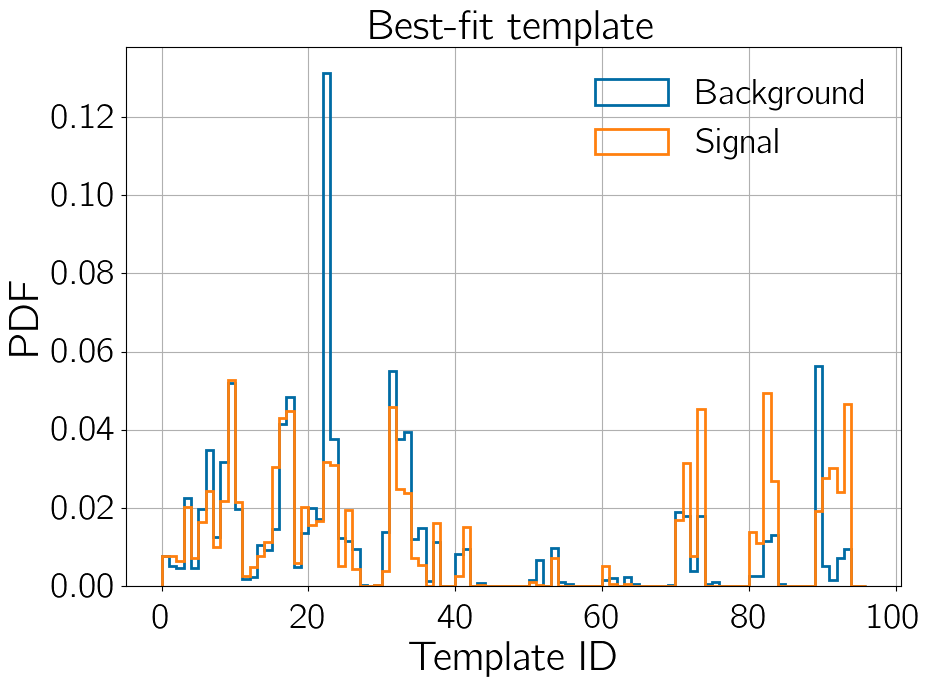

In [7]:
bkg_template_best = np.take_along_axis(bkg_results['idx_template_best'],bkg_results['idx_pol'].astype(int)[:,None],axis=1)[:,0]
sig_template_best = np.take_along_axis(sig_results['idx_template_best'],sig_results['idx_pol'].astype(int)[:,None],axis=1)[:,0]

bins = np.arange(n_templates+1)

bkg_ids, bkg_counts = np.unique(bkg_template_best,return_counts=True)
sig_ids, sig_counts = np.unique(sig_template_best,return_counts=True)

bkg_idcs_sort = np.argsort(bkg_counts)[::-1]
bkg_ids       = bkg_ids[bkg_idcs_sort]
bkg_counts    = bkg_counts[bkg_idcs_sort]
print(bkg_ids,bkg_counts)

sig_idcs_sort = np.argsort(sig_counts)[::-1]
sig_ids       = sig_ids[sig_idcs_sort]
sig_counts    = sig_counts[sig_idcs_sort]
print(sig_ids,sig_counts)

plt.hist(bkg_template_best,bins=bins,histtype='step',linewidth=2,density=True,label='Background')
plt.hist(sig_template_best,bins=bins,histtype='step',linewidth=2,density=True,label='Signal')

plt.xlabel('Template ID')
plt.ylabel('PDF')
plt.title('Best-fit template')

plt.legend()

plt.show()

[22 89 31  9 17 16 33 23 32  6  8  3 20 10  5 70 73 71 21 35 15 30 19 83
  7 24 34 25 82 37 13 53 26 93 41 14 40  0 92 51  1 90 18  4  2 72 81 80
 12 63 61 11 60 50 91 36 75 54 43 55 74 64 84 27 29 69] [527 226 221 208 194 166 158 151 151 140 127  90  80  79  79  76  72  72
  69  59  58  55  54  52  50  49  48  46  46  45  42  39  38  38  38  37
  33  31  29  27  21  21  19  18  18  15  10  10   9   9   8   7   6   6
   6   5   4   4   3   2   2   2   2   1   1   1]
[ 9 82 93 31 73 17 16 22 71 23 15 91 90 83 32  6 92 33  8 10 19  3 25 89
 70 21  5 37 20 41 80 14 81  7 72  1  0 13 53 34  4  2 18 35 24 60 12 26
 30 11 40 50 61 63 43 29 51 44 42 62 27] [527 494 466 458 453 448 430 318 315 309 304 301 277 268 247 242 241 238
 218 216 202 202 195 191 170 166 164 160 155 150 137 113 110 100  78  77
  77  76  72  71  71  63  60  53  52  52  48  43  38  26  26  10   5   5
   3   3   2   1   1   1   1]


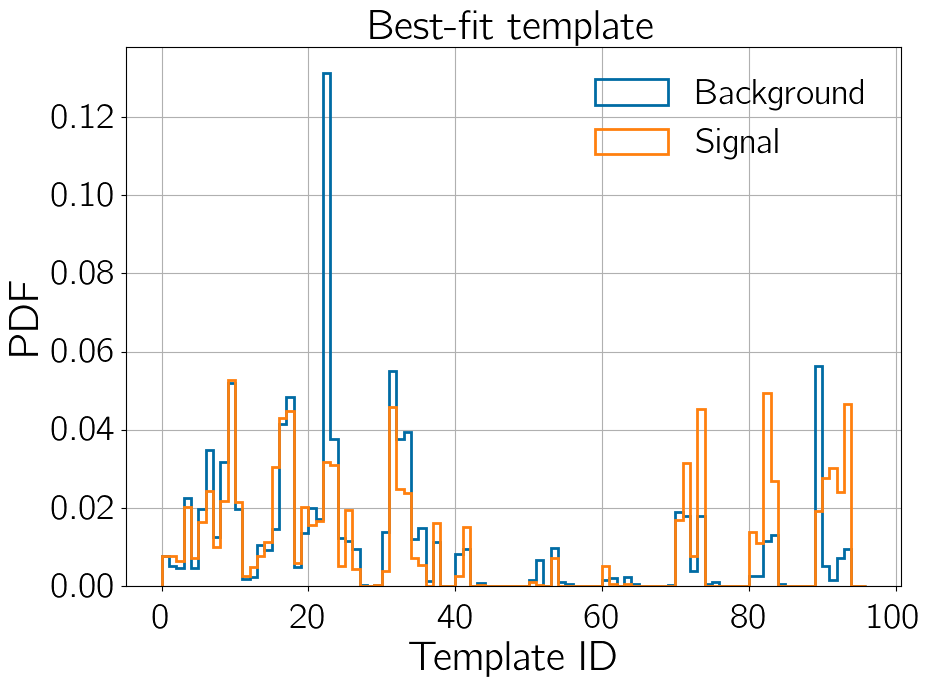

In [22]:
bkg_template_best = np.take_along_axis(bkg_results['idx_template_best'],bkg_results['idx_pol'].astype(int)[:,None],axis=1)[:,0]
sig_template_best = np.take_along_axis(sig_results['idx_template_best'],sig_results['idx_pol'].astype(int)[:,None],axis=1)[:,0]

bins = np.arange(n_templates+1)

bkg_ids, bkg_counts = np.unique(bkg_template_best,return_counts=True)
sig_ids, sig_counts = np.unique(sig_template_best,return_counts=True)

bkg_idcs_sort = np.argsort(bkg_counts)[::-1]
bkg_ids       = bkg_ids[bkg_idcs_sort]
bkg_counts    = bkg_counts[bkg_idcs_sort]
print(bkg_ids,bkg_counts)

sig_idcs_sort = np.argsort(sig_counts)[::-1]
sig_ids       = sig_ids[sig_idcs_sort]
sig_counts    = sig_counts[sig_idcs_sort]
print(sig_ids,sig_counts)

plt.hist(bkg_template_best,bins=bins,histtype='step',linewidth=2,density=True,label='Background')
plt.hist(sig_template_best,bins=bins,histtype='step',linewidth=2,density=True,label='Signal')

plt.xlabel('Template ID')
plt.ylabel('PDF')
plt.title('Best-fit template')

plt.legend()

plt.show()

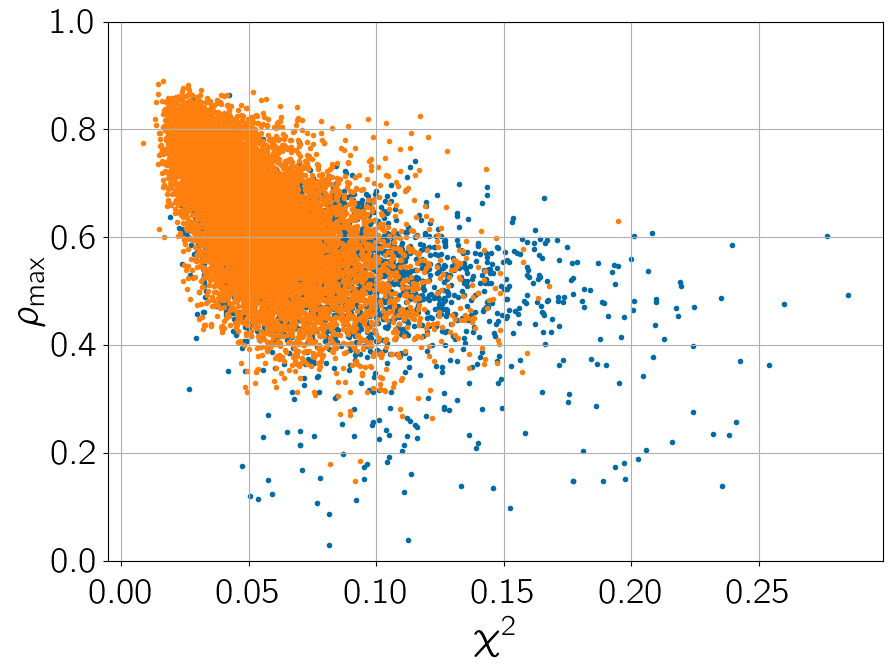

In [19]:
plt.scatter(bkg_results['chi2_min'],bkg_results['corr_max'])
plt.scatter(sig_results['chi2_min'],sig_results['corr_max'])
plt.ylim([0,1])
plt.xlabel(r'$\chi^2$')
plt.ylabel(r'$\rho_{\max}$')
plt.show()

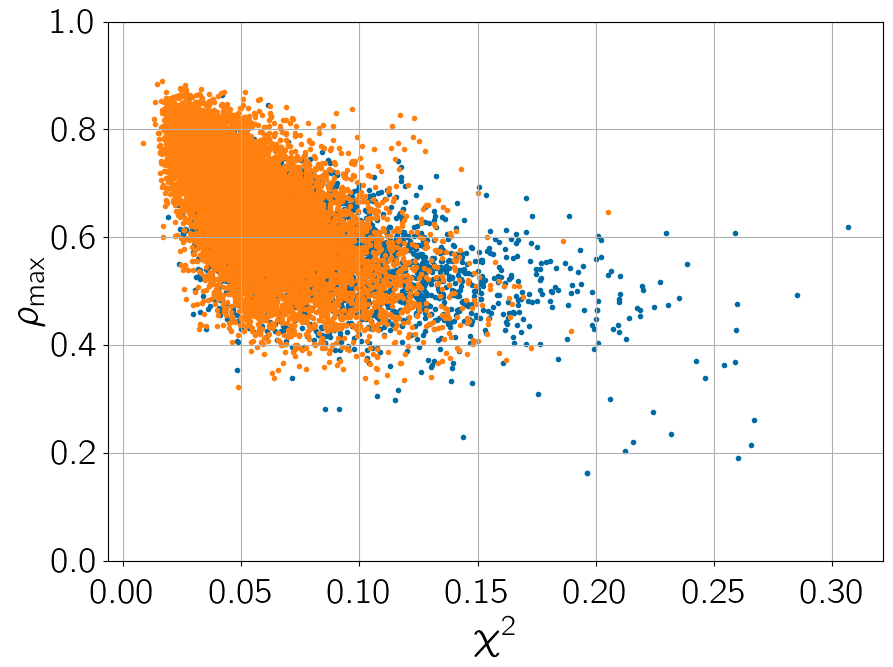

In [25]:
plt.scatter(bkg_results['chi2_min'],bkg_results['corr_max'])
plt.scatter(sig_results['chi2_min'],sig_results['corr_max'])
plt.ylim([0,1])
plt.xlabel(r'$\chi^2$')
plt.ylabel(r'$\rho_{\max}$')
plt.show()

## Look at different TS candidates where you combine X and Y

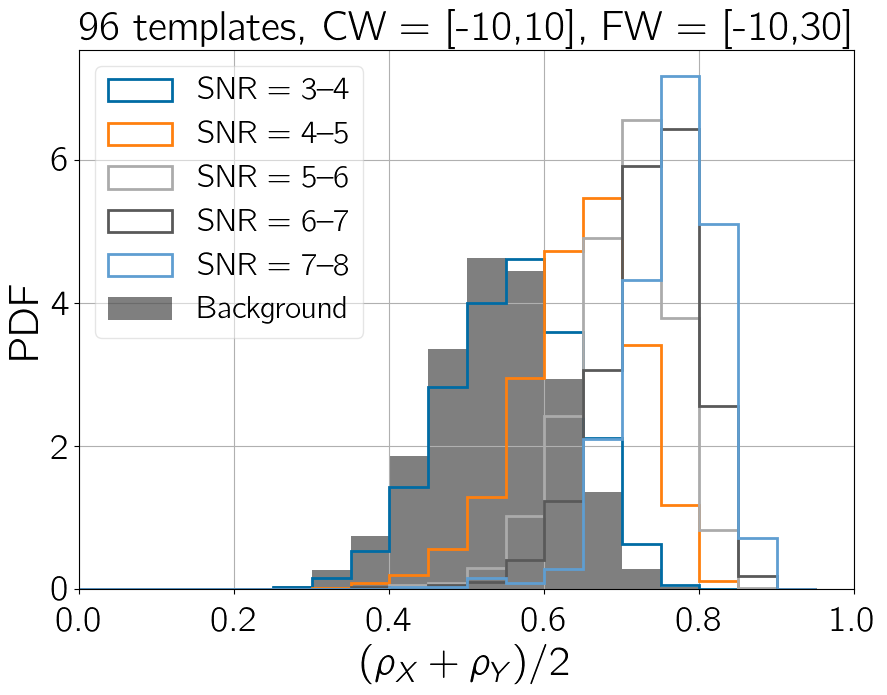

In [17]:
corr_bins = np.arange(0,1,.05)

for snr_bin, snr_mask in zip( snr_masks.keys(), snr_masks.values() ):
    plt.hist(sig_results['corr_mean'][snr_mask],bins=corr_bins,density=True,label=f'SNR = {snr_bin}--{snr_bin+snr_bin_width}',histtype='step',linewidth=2.)

plt.hist(bkg_results['corr_mean'],color='k',bins=corr_bins,density=True,alpha=.5,label='Background',)
#plt.hist(bkg_ts_1khz,color='k',bins=ts_bins,density=True,alpha=.5,label='Background for L1 @ 1kHz')

#plt.axvline(ts_90,color='k',ls='--',label=r'90\% background rejection')

plt.xlim([0,1])
#plt.yscale('log')

plt.xlabel(r'$(\rho_X + \rho_Y)/2$')
plt.ylabel('PDF')
#plt.ylabel(r'$1-{\rm CDF}$')
plt.title(title_str)

plt.legend(fontsize=23,frameon=True,framealpha=.5,loc='upper left')

plt.show()

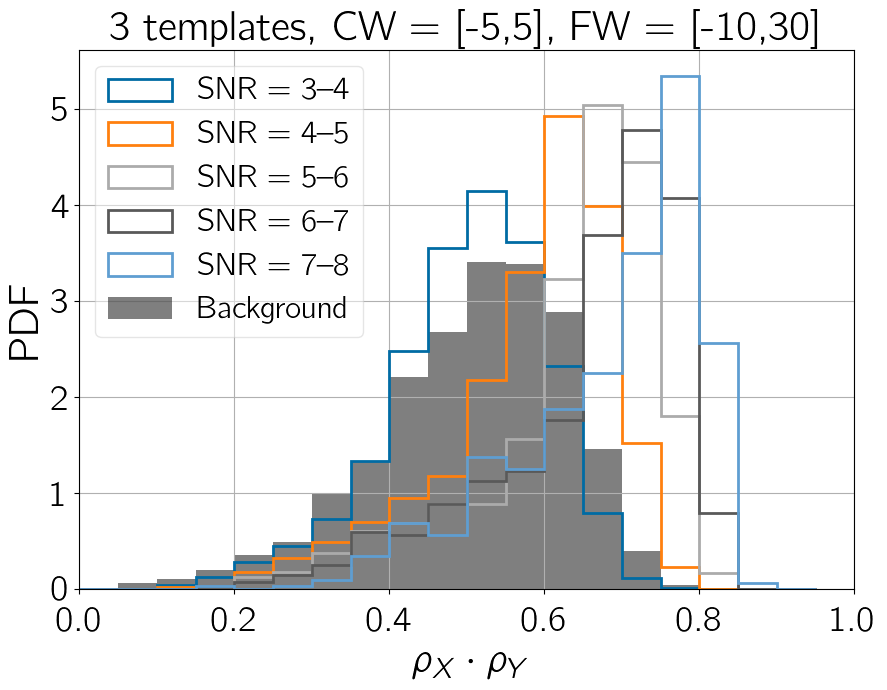

In [18]:
corr_bins = np.arange(0,1,.05)

for snr_bin, snr_mask in zip( snr_masks.keys(), snr_masks.values() ):
    plt.hist(sig_results['corr_prod'][snr_mask],bins=corr_bins,density=True,label=f'SNR = {snr_bin}--{snr_bin+snr_bin_width}',histtype='step',linewidth=2.)

plt.hist(bkg_results['corr_prod'],color='k',bins=corr_bins,density=True,alpha=.5,label='Background')
#plt.hist(bkg_ts_1khz,color='k',bins=ts_bins,density=True,alpha=.5,label='Background for L1 @ 1kHz')

#plt.axvline(ts_90,color='k',ls='--',label=r'90\% background rejection')

plt.xlim([0,1])

plt.xlabel(r'$\rho_X \cdot \rho_Y$')
plt.ylabel('PDF')
#plt.ylabel(r'$1-{\rm CDF}$')
plt.title(title_str)

plt.legend(fontsize=23,frameon=True,framealpha=.5,loc='upper left')

plt.show()

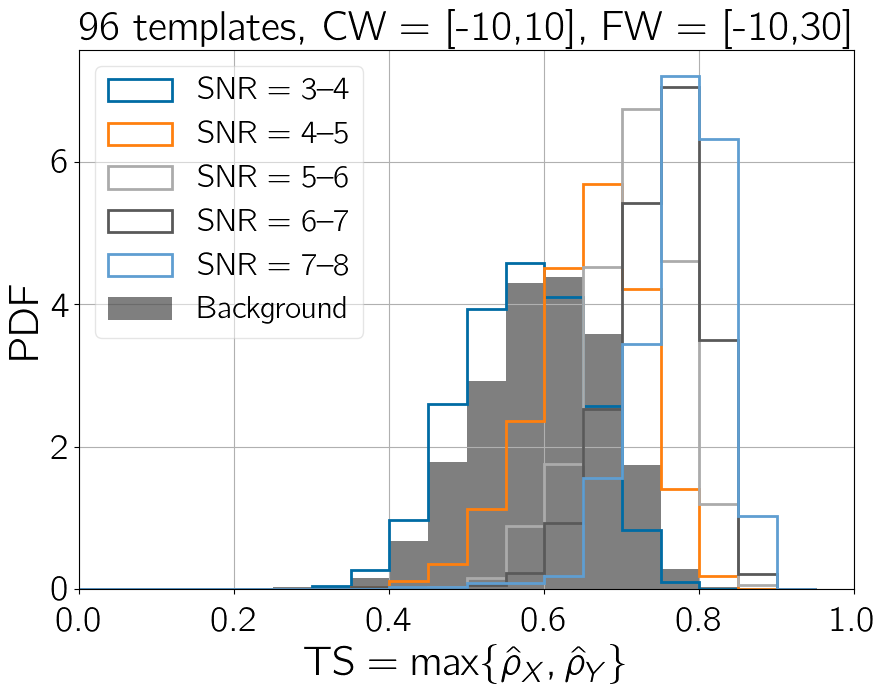

In [8]:
corr_bins = np.arange(0,1,.05)

for snr_bin, snr_mask in zip( snr_masks.keys(), snr_masks.values() ):
    plt.hist(sig_results['corr_max'][snr_mask],bins=corr_bins,density=True,label=f'SNR = {snr_bin}--{snr_bin+snr_bin_width}',histtype='step',linewidth=2.)

plt.hist(bkg_results['corr_max'],color='k',bins=corr_bins,density=True,alpha=.5,label='Background')
#plt.hist(bkg_ts_1khz,color='k',bins=ts_bins,density=True,alpha=.5,label='Background for L1 @ 1kHz')

#plt.axvline(ts_90,color='k',ls='--',label=r'90\% background rejection')

plt.xlim([0,1])

#plt.xlabel(r'$\max(\rho_X,\rho_Y)$')
plt.xlabel(r'${\rm TS} = \max \lbrace{ \hat{\rho}_X,\hat{\rho}_Y \rbrace} $')
plt.ylabel('PDF')
#plt.ylabel(r'$1-{\rm CDF}$')
plt.title(title_str)
#plt.title('FLT-1 TF')

#plt.text(0.01,2.8,'GRAND preliminary',color='crimson')

plt.legend(fontsize=23,frameon=True,framealpha=.5,loc='upper left')

if savefig:
    plot_name = 'ts_TF'#'ts_TF_' + param_str
    
    plt.savefig( os.path.join(plot_dir,plot_name+'.png') )
    plt.savefig( os.path.join(plot_dir,plot_name+'.pdf') )

plt.show()

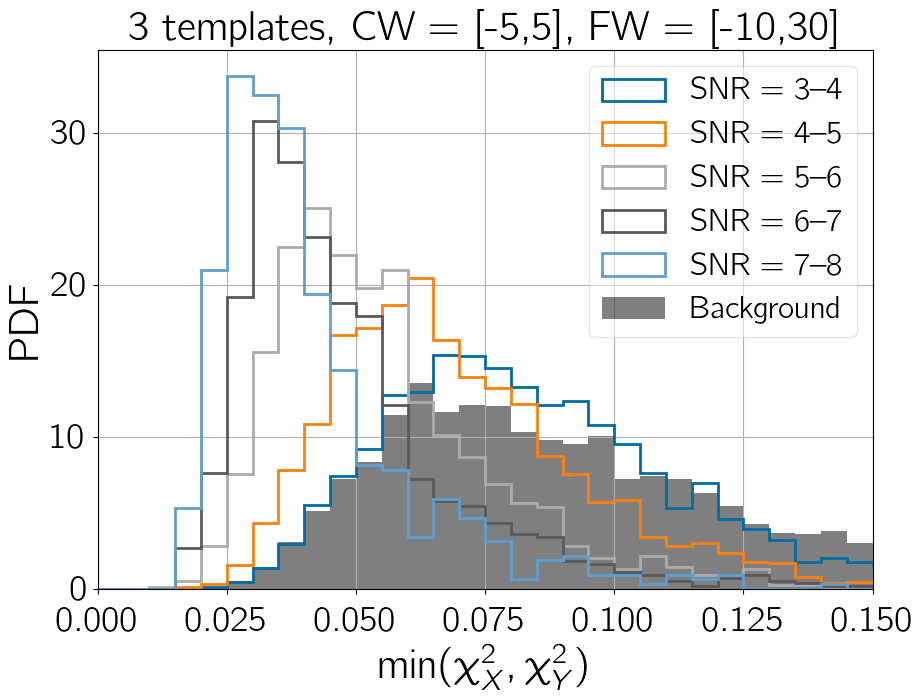

In [20]:
chi2_bins = np.arange(0,0.25,.005)

for snr_bin, snr_mask in zip( snr_masks.keys(), snr_masks.values() ):
    plt.hist(sig_results['chi2_min'][snr_mask],bins=chi2_bins,density=True,label=f'SNR = {snr_bin}--{snr_bin+snr_bin_width}',histtype='step',linewidth=2.)

plt.hist(bkg_results['chi2_min'],color='k',bins=chi2_bins,density=True,alpha=.5,label='Background')
#plt.hist(bkg_ts_1khz,color='k',bins=ts_bins,density=True,alpha=.5,label='Background for L1 @ 1kHz')

#plt.axvline(ts_90,color='k',ls='--',label=r'90\% background rejection')

plt.xlim([0,.15])

plt.xlabel(r'$\min(\chi^2_X,\chi^2_Y)$')
plt.ylabel('PDF')
#plt.ylabel(r'${\rm CDF}$')
plt.title(title_str)

#plt.text(1.55,1.2,'GRAND preliminary', color='crimson')

plt.legend(fontsize=23,frameon=True,framealpha=.5,loc='upper right')

plt.show()

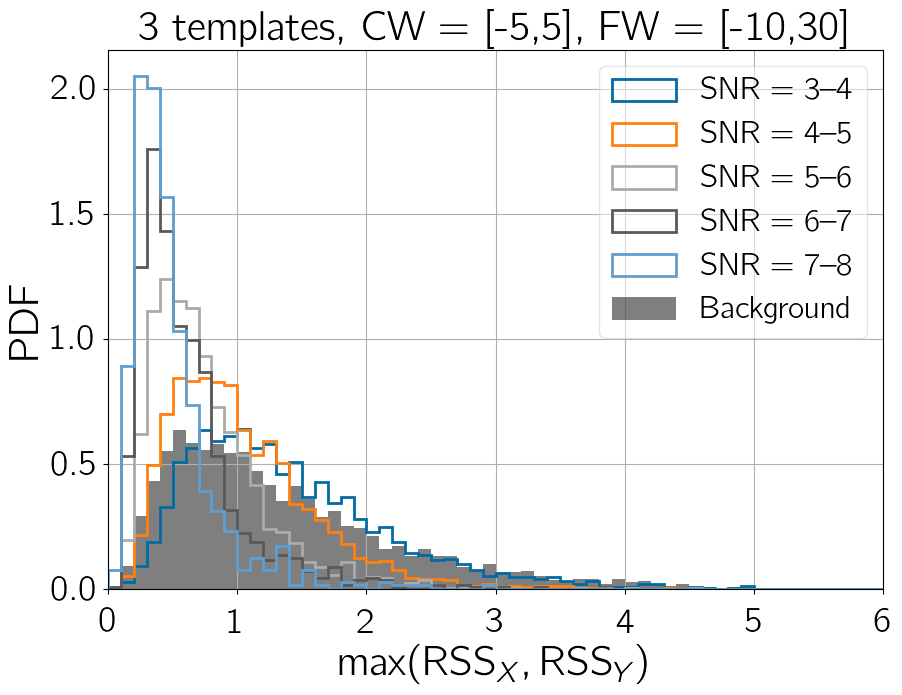

In [21]:
rss_bins = np.arange(0,7,.1)

for snr_bin, snr_mask in zip( snr_masks.keys(), snr_masks.values() ):
    plt.hist(sig_results['rss_max'][snr_mask],bins=rss_bins,density=True,label=f'SNR = {snr_bin}--{snr_bin+snr_bin_width}',histtype='step',linewidth=2.)

plt.hist(bkg_results['rss_max'],color='k',bins=rss_bins,density=True,alpha=.5,label='Background')
#plt.hist(bkg_ts_1khz,color='k',bins=ts_bins,density=True,alpha=.5,label='Background for L1 @ 1kHz')

#plt.axvline(ts_90,color='k',ls='--',label=r'90\% background rejection')

plt.xlim([0,6])
#plt.yscale('log')

plt.xlabel(r'$\max({\rm RSS}_X,{\rm RSS}_Y)$')
plt.ylabel('PDF')
#plt.ylabel(r'${\rm CDF}$')
plt.title(title_str)

plt.legend(fontsize=23,frameon=True,framealpha=.5,loc='upper right')

plt.show()

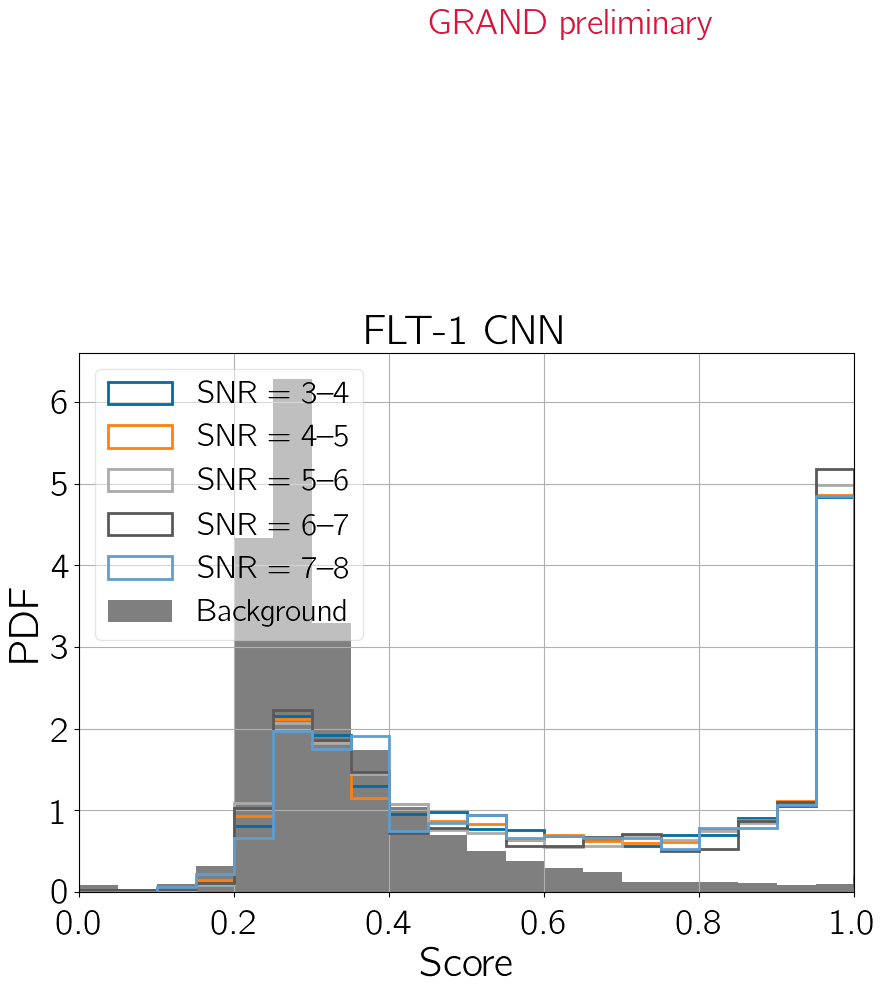

In [10]:
score_bins = np.arange(0,1.1,.05)

for snr_bin, snr_mask in zip( snr_masks.keys(), snr_masks.values() ):
    plt.hist(sig_score_ML[snr_mask],bins=score_bins,density=True,label=f'SNR = {snr_bin}--{snr_bin+snr_bin_width}',histtype='step',linewidth=2.)

plt.hist(bkg_score_ML,color='k',bins=score_bins,density=True,alpha=.5,label='Background')
#plt.hist(bkg_ts_1khz,color='k',bins=ts_bins,density=True,alpha=.5,label='Background for L1 @ 1kHz')

#plt.axvline(ts_90,color='k',ls='--',label=r'90\% background rejection')

plt.xlim([0,1])
#plt.yscale('log')

plt.xlabel('Score')
plt.ylabel('PDF')
plt.title('FLT-1 CNN')

plt.text(0.45,10.5,'GRAND preliminary', color='crimson')

plt.legend(fontsize=23,frameon=True,framealpha=.5,loc='upper left')

if savefig:
    plot_name = 'score_CNN' #+ param_str
    
    plt.savefig( os.path.join(plot_dir,plot_name+'.png') )
    plt.savefig( os.path.join(plot_dir,plot_name+'.pdf') )

plt.show()

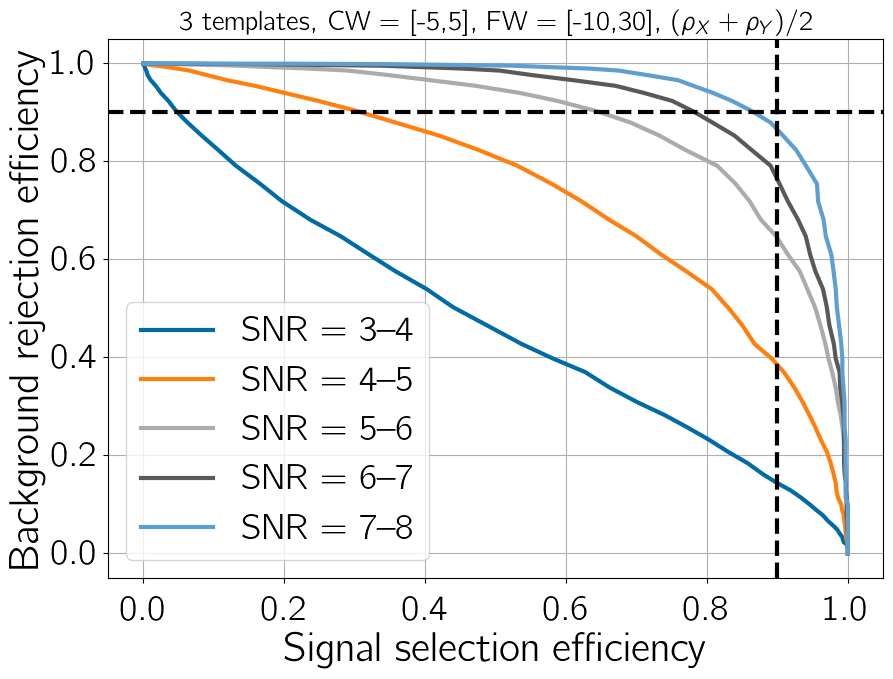

In [22]:
corr_thresh = np.arange(0,1,.01)

bkg_sel_eff = get_selection_efficiency(bkg_results['corr_mean'],corr_thresh)
bkg_rej_eff = 1 - bkg_sel_eff

# bkg_sel_eff_1khz = get_selection_efficiency(bkg_ts_1khz,ts_thresh)
# bkg_rej_eff_1khz = 1 - bkg_sel_eff_1khz

for snr_bin, snr_mask in zip( snr_masks.keys(), snr_masks.values() ):
    sig_sel_eff = get_selection_efficiency(sig_results['corr_mean'][snr_mask],corr_thresh)
    plt.plot(sig_sel_eff,bkg_rej_eff,label=f'SNR = {snr_bin}--{snr_bin+snr_bin_width}')

plt.axhline(0.9,color='k',linestyle='--')
plt.axvline(0.9,color='k',linestyle='--')

plt.xlabel('Signal selection efficiency')
plt.ylabel('Background rejection efficiency')
plt.title(title_str+r', $(\rho_X + \rho_Y)/2$',fontsize=20)

plt.legend(frameon=True,framealpha=.8)

if savefig:
    plot_name = 'sig_sel_vs_bkg_rej_efficiency_rho_mean_' + param_str
    
    plt.savefig( os.path.join(plot_dir,plot_name+'.png') )
    plt.savefig( os.path.join(plot_dir,plot_name+'.pdf') )

plt.show()

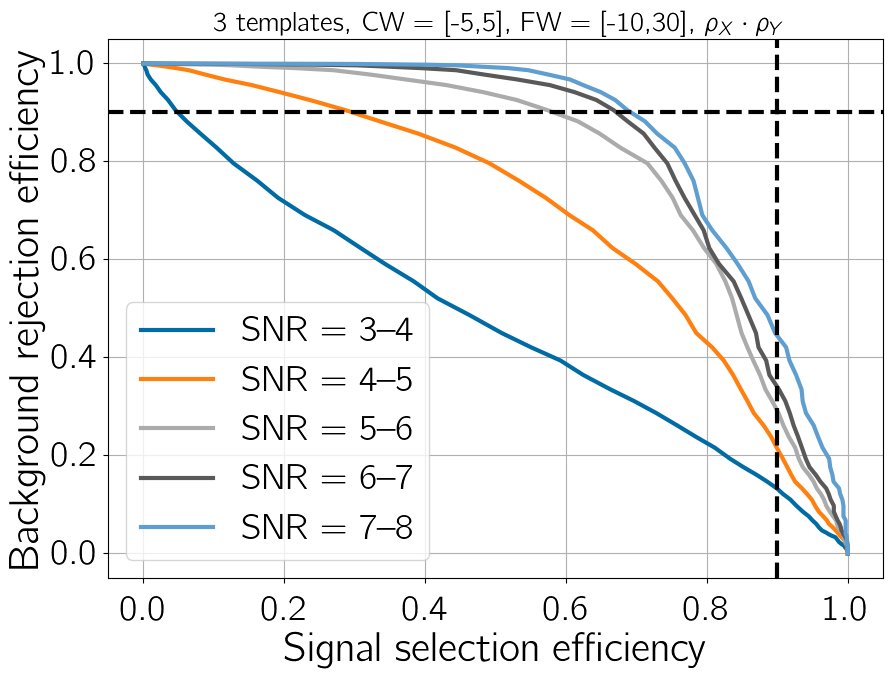

In [23]:
corr_thresh = np.arange(0,1,.01)

bkg_sel_eff = get_selection_efficiency(bkg_results['corr_prod'],corr_thresh)
bkg_rej_eff = 1 - bkg_sel_eff

# bkg_sel_eff_1khz = get_selection_efficiency(bkg_ts_1khz,ts_thresh)
# bkg_rej_eff_1khz = 1 - bkg_sel_eff_1khz

for snr_bin, snr_mask in zip( snr_masks.keys(), snr_masks.values() ):
    sig_sel_eff = get_selection_efficiency(sig_results['corr_prod'][snr_mask],corr_thresh)
    plt.plot(sig_sel_eff,bkg_rej_eff,label=f'SNR = {snr_bin}--{snr_bin+snr_bin_width}')

plt.axhline(0.9,color='k',linestyle='--')
plt.axvline(0.9,color='k',linestyle='--')

plt.xlabel('Signal selection efficiency')
plt.ylabel('Background rejection efficiency')
plt.title(title_str+r', $\rho_X \cdot \rho_Y$',fontsize=20)

plt.legend(frameon=True,framealpha=.8)

if savefig:
    plot_name = 'sig_sel_vs_bkg_rej_efficiency_TF' # + param_str
    
    plt.savefig( os.path.join(plot_dir,plot_name+'.png') )
    plt.savefig( os.path.join(plot_dir,plot_name+'.pdf') )

plt.show()

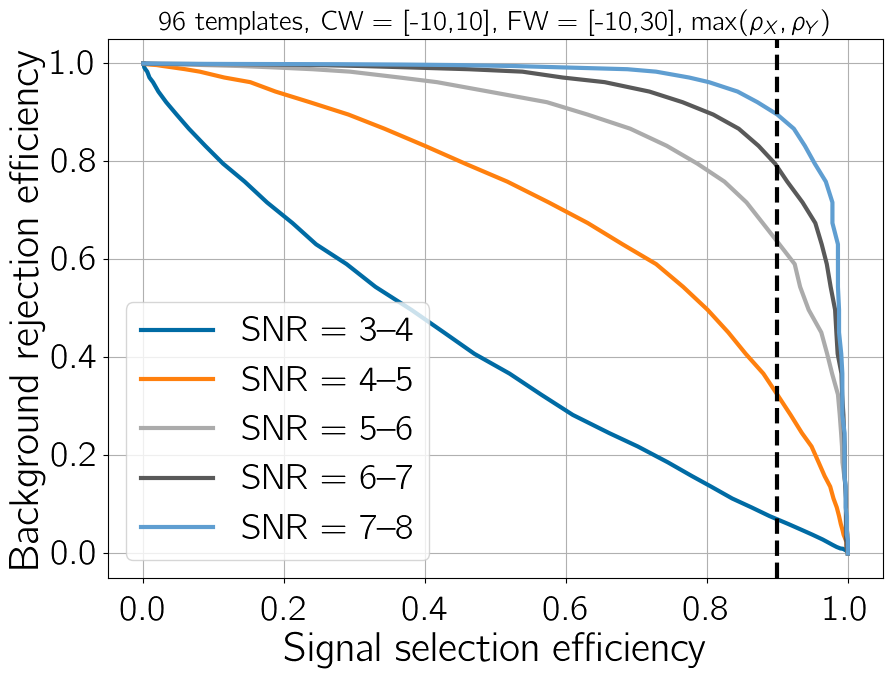

In [31]:
corr_thresh = np.arange(0,1,.01)

bkg_sel_eff = get_selection_efficiency(bkg_results['corr_max'],corr_thresh)
bkg_rej_eff = 1 - bkg_sel_eff

# bkg_sel_eff_1khz = get_selection_efficiency(bkg_ts_1khz,ts_thresh)
# bkg_rej_eff_1khz = 1 - bkg_sel_eff_1khz

for snr_bin, snr_mask in zip( snr_masks.keys(), snr_masks.values() ):
    sig_sel_eff = get_selection_efficiency(sig_results['corr_max'][snr_mask],corr_thresh)
    plt.plot(sig_sel_eff,bkg_rej_eff,label=f'SNR = {snr_bin}--{snr_bin+snr_bin_width}')

#plt.axhline(0.9,color='k',linestyle='--')
plt.axvline(0.9,color='k',linestyle='--')

plt.xlabel('Signal selection efficiency')
plt.ylabel('Background rejection efficiency')
plt.title(title_str+r', $\max(\rho_X,\rho_Y)$',fontsize=20)
#plt.title('FLT-1 TF')

#plt.text(0.43,0.,'GRAND preliminary', color='crimson')

plt.legend(frameon=True,framealpha=.8)

if savefig:
    plot_name = 'sig_sel_vs_bkg_rej_efficiency_TF' # + param_str
    
    plt.savefig( os.path.join(plot_dir,plot_name+'.png') )
    plt.savefig( os.path.join(plot_dir,plot_name+'.pdf') )

plt.show()

In [42]:
x = np.arange(0,0.25,.005)
-x[::-1]

array([-0.245, -0.24 , -0.235, -0.23 , -0.225, -0.22 , -0.215, -0.21 ,
       -0.205, -0.2  , -0.195, -0.19 , -0.185, -0.18 , -0.175, -0.17 ,
       -0.165, -0.16 , -0.155, -0.15 , -0.145, -0.14 , -0.135, -0.13 ,
       -0.125, -0.12 , -0.115, -0.11 , -0.105, -0.1  , -0.095, -0.09 ,
       -0.085, -0.08 , -0.075, -0.07 , -0.065, -0.06 , -0.055, -0.05 ,
       -0.045, -0.04 , -0.035, -0.03 , -0.025, -0.02 , -0.015, -0.01 ,
       -0.005, -0.   ])

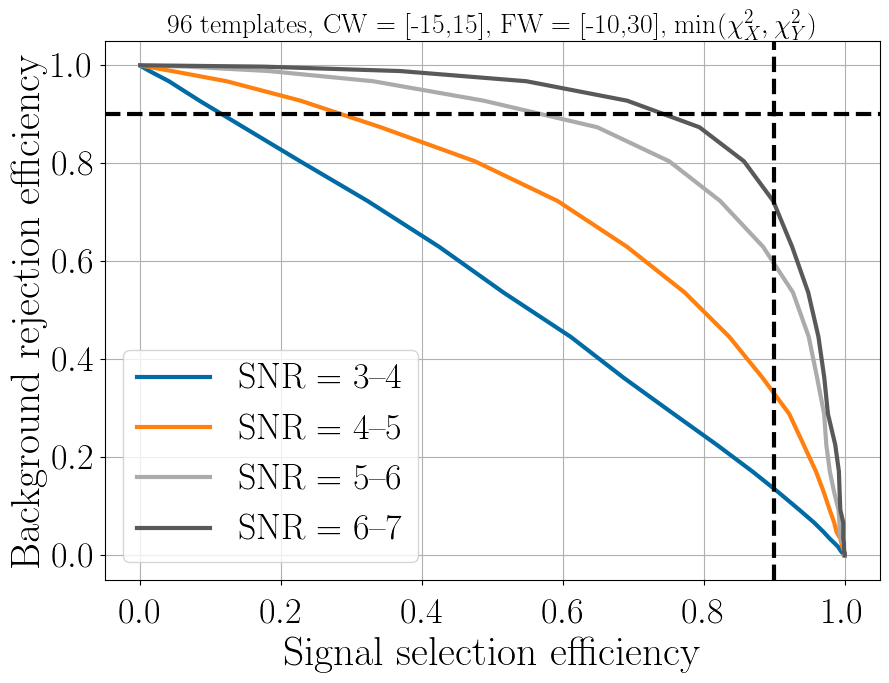

In [5]:
chi2_thresh = -np.arange(0,0.25,.005)[::-1]

bkg_sel_eff = get_selection_efficiency(-bkg_results['chi2_min'],chi2_thresh)
bkg_rej_eff = 1 - bkg_sel_eff

# bkg_sel_eff_1khz = get_selection_efficiency(bkg_ts_1khz,ts_thresh)
# bkg_rej_eff_1khz = 1 - bkg_sel_eff_1khz

for snr_bin, snr_mask in zip( snr_masks.keys(), snr_masks.values() ):
    sig_sel_eff = get_selection_efficiency(-sig_results['chi2_min'][snr_mask],chi2_thresh)
    plt.plot(sig_sel_eff,bkg_rej_eff,label=f'SNR = {snr_bin}--{snr_bin+snr_bin_width}')

plt.axhline(0.9,color='k',linestyle='--')
plt.axvline(0.9,color='k',linestyle='--')

plt.xlabel('Signal selection efficiency')
plt.ylabel('Background rejection efficiency')
plt.title(title_str+r', $\min(\chi^2_X,\chi^2_Y)$',fontsize=20)

plt.legend(frameon=True,framealpha=.8)

if savefig:
    plot_name = 'sig_sel_vs_bkg_rej_efficiency_TF' # + param_str
    
    plt.savefig( os.path.join(plot_dir,plot_name+'.png') )
    plt.savefig( os.path.join(plot_dir,plot_name+'.pdf') )

plt.show()

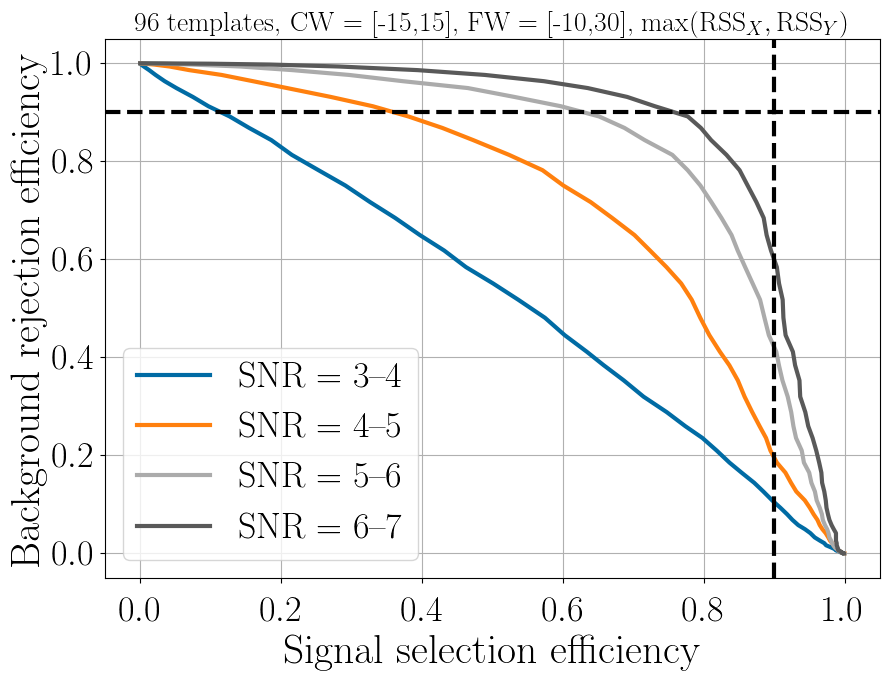

In [7]:
rss_thresh = -np.arange(0,7,.1)[::-1]

bkg_sel_eff = get_selection_efficiency(-bkg_results['rss_max'],rss_thresh)
bkg_rej_eff = 1 - bkg_sel_eff

# bkg_sel_eff_1khz = get_selection_efficiency(bkg_ts_1khz,ts_thresh)
# bkg_rej_eff_1khz = 1 - bkg_sel_eff_1khz

for snr_bin, snr_mask in zip( snr_masks.keys(), snr_masks.values() ):
    sig_sel_eff = get_selection_efficiency(-sig_results['rss_max'][snr_mask],rss_thresh)
    plt.plot(sig_sel_eff,bkg_rej_eff,label=f'SNR = {snr_bin}--{snr_bin+snr_bin_width}')

plt.axhline(0.9,color='k',linestyle='--')
plt.axvline(0.9,color='k',linestyle='--')

plt.xlabel('Signal selection efficiency')
plt.ylabel('Background rejection efficiency')
plt.title(title_str+r', $\max({\rm RSS}_X,{\rm RSS}_Y)$',fontsize=20)

plt.legend(frameon=True,framealpha=.8)

if savefig:
    plot_name = 'sig_sel_vs_bkg_rej_efficiency_TF' # + param_str
    
    plt.savefig( os.path.join(plot_dir,plot_name+'.png') )
    plt.savefig( os.path.join(plot_dir,plot_name+'.pdf') )

plt.show()

## Check the effect of reducing templates
See also `reduce_templates.ipynb`

In [26]:
n_templates_vals   = [1,3,5,10,26,96]#[1,3,6,11,20,96] #[1,2,3,9,16,34,96]
corr_window        = [-10,10]
fit_window         = [-10,30]
corr_thresh        = np.arange(0,1,.01)
pol                = 'XY'
n_pol              = len(pol)
dataset            = 'train'
snr_bin_width      = 1
snr_bin_edges      = np.linspace(3,8.1,snr_bin_width)
sig_sel_eff_thresh = 0.9

range_zenith  = [30.6,87.35]
range_omega   = [0.,2.]
n_bins_zenith = 10
n_bins_omega  = 10

# sig_test_file = f'/sps/grand/pcorrea/nutrig/database/sig/sig_dataset_nutrig_gp13_{dataset}_seed_300.npz'
# snr_masks     = get_snr_masks(sig_dataset_file,snr_bin_width=snr_bin_width)

# bkg_rej_eff_vals   = np.zeros((len(n_templates_vals),len(snr_masks)))

bkg_rej_eff_vals   = np.zeros((len(n_templates_vals)))

for k, n_templates in enumerate(n_templates_vals): 
    param_str = f'templates_{n_templates}_cw_{corr_window[0]}_{corr_window[1]}_fw_{fit_window[0]}_{fit_window[1]}'

    #bkg_res_file = f'/sps/grand/pcorrea/nutrig/template/results/results_template_FLT_{pol}_bkg_dataset_nutrig_gp13_{dataset}_seed_300_{param_str}.npz'
    bkg_res_file = f'/sps/grand/pcorrea/nutrig/template/results/results_template_FLT_{pol}_bkg_dataset_nutrig_gp13_th1_55_th2_35_{dataset}_seed_300_{param_str}.npz' # 1 kHz
    sig_res_file = f'/sps/grand/pcorrea/nutrig/template/results_bias/results_template_FLT_{pol}_sig_dataset_bias_test_bins_{n_bins_zenith}x{n_bins_omega}_zenith_{range_zenith[0]}_{range_zenith[1]}_omega_diff_{range_omega[0]}_{range_omega[1]}_seed_300_{param_str}.npz'

    bkg_results = load_results(bkg_res_file,n_pol)
    sig_results = load_results(sig_res_file,n_pol)

    bkg_sel_eff = get_selection_efficiency(bkg_results['corr_max'],corr_thresh)

    for j, snr_mask in enumerate( snr_masks.values() ):
        #sig_sel_eff = get_selection_efficiency(sig_results['corr_max'][snr_mask],corr_thresh)
        sig_sel_eff = get_selection_efficiency(sig_results['corr_max'],corr_thresh)
        idx         = np.where(sig_sel_eff>=sig_sel_eff_thresh)[0][-1]
        #bkg_rej_eff_vals[k,j] = 1 - bkg_sel_eff[idx]
        bkg_rej_eff_vals[k] = 1 - bkg_sel_eff[idx]

#print(bkg_rej_eff_vals)

In [ ]:
n_templates   = 2
corr_window   = [-15,15]
fit_window    = [-10,30]
pol           = 'XY'
n_pol         = len(pol)
dataset       = 'train' # or 'test' for final checks
snr_bin_width = 1

param_str = f'templates_{n_templates}_cw_{corr_window[0]}_{corr_window[1]}_fw_{fit_window[0]}_{fit_window[1]}'
title_str = f'{n_templates} templates, CW = [{corr_window[0]},{corr_window[1]}], FW = [{fit_window[0]},{fit_window[1]}]'

plot_dir = '/pbs/home/p/pcorrea/grand/nutrig/flt/plots'
savefig  = False

bkg_res_file     = f'/sps/grand/pcorrea/nutrig/template/results/results_template_FLT_{pol}_bkg_dataset_nutrig_gp13_{dataset}_seed_300_{param_str}.npz'
sig_res_file     = f'/sps/grand/pcorrea/nutrig/template/results/results_template_FLT_{pol}_sig_dataset_nutrig_gp13_{dataset}_seed_300_{param_str}.npz'
sig_dataset_file = f'/sps/grand/pcorrea/nutrig/database/sig/sig_dataset_nutrig_gp13_{dataset}_seed_300.npz'

bkg_results = load_results(bkg_res_file,n_pol)
sig_results = load_results(sig_res_file,n_pol)
snr_masks   = get_snr_masks(sig_dataset_file,snr_bin_width=snr_bin_width)

In [ ]:
for snr_bin, snr_mask in zip( snr_masks.keys(), snr_masks.values() ):
    plt.hist(sig_results['corr_max'][snr_mask],bins=corr_bins,density=True,label=f'SNR = {snr_bin}--{snr_bin+snr_bin_width}',histtype='step',linewidth=2.)

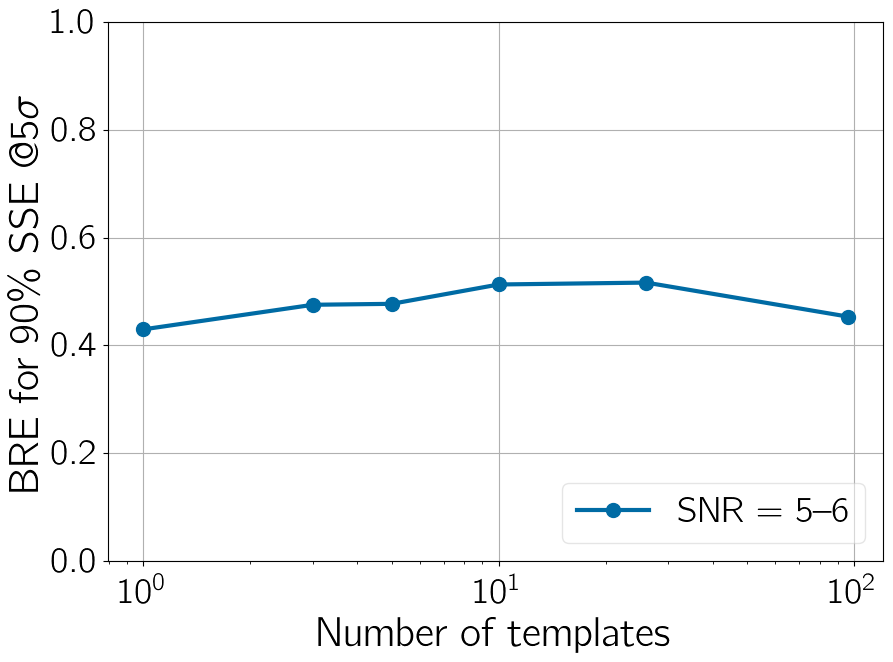

In [27]:
# for i in range(bkg_rej_eff_vals.shape[1]):
#     plt.plot(n_templates_vals,bkg_rej_eff_vals[:,i],label=f'SNR = {snr_bin_edges[i]}--{snr_bin_edges[i]+snr_bin_width}',marker='o',markersize=10)

plt.plot(n_templates_vals,bkg_rej_eff_vals,label=f'SNR = 5--6',marker='o',markersize=10)

plt.xscale('log')
plt.ylim([0,1])

plt.xlabel('Number of templates')
plt.ylabel('BRE for 90\% SSE @$5\sigma$')

plt.legend(frameon=True,framealpha=.5,loc='lower right')

# if savefig:
#     plot_name = 'sel_efficiency_vs_n_templates_' + param_str
    
#     plt.savefig( os.path.join(plot_dir,plot_name+'.png') )
#     plt.savefig( os.path.join(plot_dir,plot_name+'.pdf') )

#plt.text(2.65,0.92,'GRAND preliminary', color='crimson')

plt.show()

## Look at all possible combinations of doublets
See also `choose_random_templates.ipynb`

In [4]:
n_random           = 2
trials             = np.arange(4560)
corr_window        = [-15,15]
fit_window         = [-10,30]
corr_thresh        = np.arange(0,1,.01)
pol                = 'XY'
n_pol              = len(pol)
sig_sel_eff_thresh = 0.9

sig_test_file = '/sps/grand/pcorrea/nutrig/database/sig/sig_dataset_nutrig_gp13_train_seed_300.npz'

with np.load(sig_test_file) as f:
    sig_traces = f['traces']
    sig_snr    = f['snr']
    sig_flags  = f['pretrig_flags']
    sig_snr    = tools.get_snr(sig_traces,f['inj_pulse_times'])
    sig_snr    = np.max(sig_snr[:,:2],axis=1)

snr_bin_width = 1
snr_bin_edges = np.arange(3,7.1,snr_bin_width)

snr_masks = {snr_bin : None for snr_bin in snr_bin_edges[:-1]}

for snr_bin in snr_masks.keys():
    snr_masks[snr_bin] = np.where( np.logical_and( sig_snr>=snr_bin, sig_snr<snr_bin+snr_bin_width ), True, False )

In [ ]:
bkg_rej_eff_vals   = np.zeros((len(trials),len(snr_bin_edges)-1))

for k, trial in enumerate(trials): 
    param_str = f'templates_random_{k}_{n_random}_cw_{corr_window[0]}_{corr_window[1]}_fw_{fit_window[0]}_{fit_window[1]}'

    bkg_train_res_file = f'/sps/grand/pcorrea/nutrig/template/results_random/results_template_FLT_{pol}_bkg_dataset_nutrig_gp13_train_seed_300_{param_str}.npz'
    with np.load(bkg_train_res_file) as f:
        bkg_corr_best_all     = f['corr_best']
        bkg_idx_template_best = f['idx_template_best']

    sig_train_res_file = f'/sps/grand/pcorrea/nutrig/template/results_random/results_template_FLT_{pol}_sig_dataset_nutrig_gp13_train_seed_300_{param_str}.npz'
    with np.load(sig_train_res_file) as f:
        sig_corr_best_all     = f['corr_best']
        sig_idx_template_best = f['idx_template_best']


    bkg_corr_max  = np.zeros(bkg_corr_best_all.shape[0])
    sig_corr_max  = np.zeros(sig_corr_best_all.shape[0])

    for i in range(n_pol):
        bkg_corr_best_pol = np.abs( np.take_along_axis(bkg_corr_best_all[:,i],bkg_idx_template_best[:,i,None],axis=1)[:,0] )      
        bkg_corr_max      = np.where(bkg_corr_best_pol>bkg_corr_max,bkg_corr_best_pol,bkg_corr_max)

        sig_corr_best_pol = np.abs( np.take_along_axis(sig_corr_best_all[:,i],sig_idx_template_best[:,i,None],axis=1)[:,0] )
        sig_corr_max      = np.where(sig_corr_best_pol>sig_corr_max,sig_corr_best_pol,sig_corr_max)
    
    bkg_sel_eff = get_selection_efficiency(bkg_corr_max,corr_thresh)

    for j, snr_mask in enumerate( snr_masks.values() ):
        sig_sel_eff = get_selection_efficiency(sig_corr_max[snr_mask],corr_thresh)
        idx         = np.where(sig_sel_eff>=sig_sel_eff_thresh)[0][-1]
        bkg_rej_eff_vals[k,j] = 1 - bkg_sel_eff[idx]


random_pairs = []
template_idcs = np.arange(96)

for i in template_idcs:
    for j in template_idcs[i+1:]:
        random_pair = np.array([i,j])
        random_pairs.append(random_pair)

random_pairs = np.array(random_pairs)


np.savez('/pbs/home/p/pcorrea/grand/nutrig/flt/bkg_rej_eff_random_templates.npz',
         random_pairs=random_pairs,
         bkg_rej_eff=bkg_rej_eff_vals)

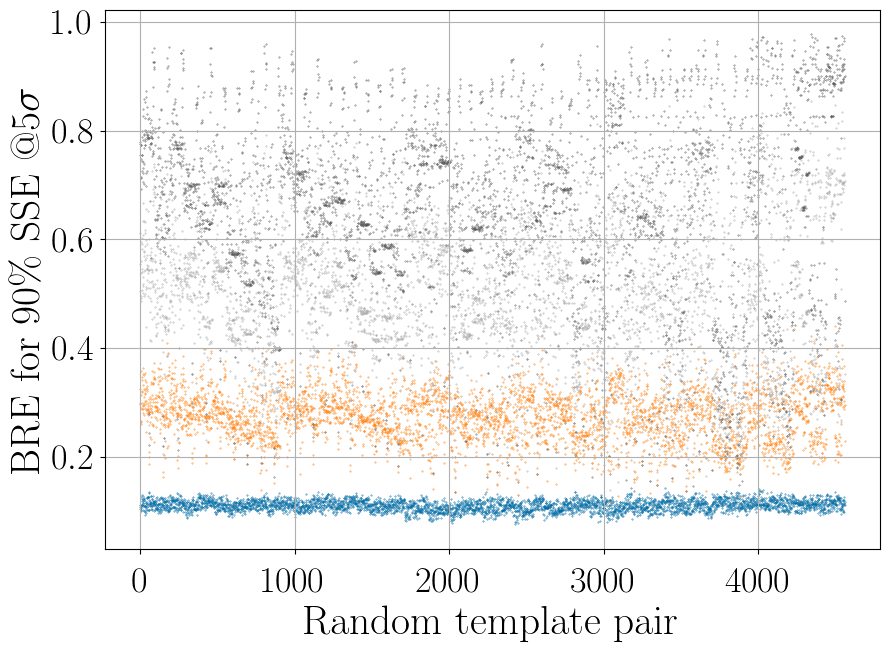

In [5]:
f = np.load('/pbs/home/p/pcorrea/grand/nutrig/flt/bkg_rej_eff_random_templates.npz')

random_pairs     = f['random_pairs']
bkg_rej_eff_vals = f['bkg_rej_eff']

for i in range(bkg_rej_eff_vals.shape[1]):
    plt.scatter(trials,bkg_rej_eff_vals[:,i],label=f'SNR = {snr_bin_edges[i]}--{snr_bin_edges[i]+snr_bin_width}',marker='o',s=.1)

plt.xlabel('Random template pair')
plt.ylabel('BRE for 90\% SSE @$5\sigma$')
# plt.title('FLT-1 TF')

#plt.legend(frameon=True,framealpha=.5)

# if savefig:
#     plot_name = 'sel_efficiency_vs_n_templates_' + param_str
    
#     plt.savefig( os.path.join(plot_dir,plot_name+'.png') )
#     plt.savefig( os.path.join(plot_dir,plot_name+'.pdf') )

#plt.text(2.65,0.92,'GRAND preliminary', color='crimson')

plt.show()

In [8]:
bkg_rej_eff_vals.shape

(4560, 4)

In [15]:
idcs_sorted               = np.argsort(bkg_rej_eff_vals[:,2])
bkg_rej_eff_5sigma_sorted = bkg_rej_eff_vals[idcs_sorted,2]
random_pairs_sorted       = random_pairs[idcs_sorted]
best_pair                 = random_pairs_sorted[-1]
best_pair_idx             = idcs_sorted[-1]

In [11]:
n_templates_original   = 96
template_idcs_original = np.arange(n_templates_original)

x,y = np.meshgrid(template_idcs_original,template_idcs_original)

In [12]:
z = np.zeros(x.shape)

k = 0
for i in template_idcs_original:
    for j in template_idcs_original[i+1:]:
        z[j,i] = bkg_rej_eff_vals[k,2]#bkg_rej_eff_5sigma_sorted[k]
        k += 1

#z = np.maximum(z,z.T)

In [13]:
np.max( bkg_rej_eff_vals, axis=0 )

array([0.1437, 0.4406, 0.8553, 0.9772])

/scratch/users/p/pcorrea/ipykernel_20798/2306102795.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  pcolor = ax.pcolormesh(x,y,z,vmin=0,vmax=1,cmap='Blues')


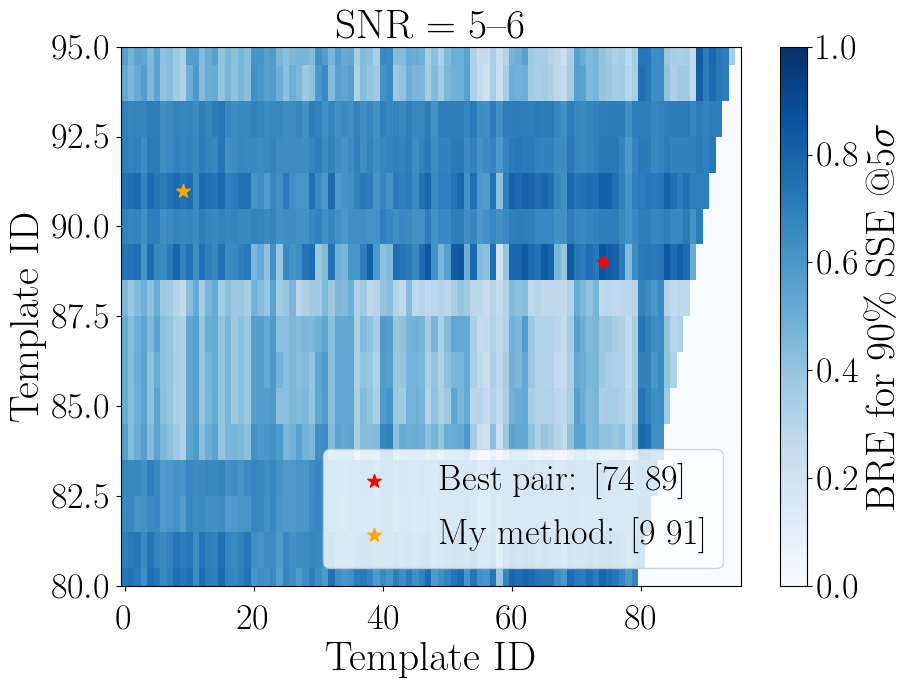

In [14]:
fig, ax = plt.subplots()

pcolor = ax.pcolormesh(x,y,z,vmin=0,vmax=1,cmap='Blues')
cbar   = fig.colorbar(pcolor,ax=ax,label='BRE for 90\% SSE @$5\sigma$')

ax.scatter(best_pair[0],best_pair[-1],marker='*',s=100,color='r',label=f'Best pair: {best_pair}')
ax.scatter(9,91,marker='*',s=100,color='orange',label='My method: {[9 91]}')

# ax.set_xlim([80,95])
ax.set_ylim([80,95])

ax.set_xlabel('Template ID')
ax.set_ylabel('Template ID')

ax.set_title('SNR = 5--6')

ax.legend(frameon=True,framealpha=.8,loc='lower right')

plt.show()

In [24]:
n_templates   = 2
corr_window   = [-15,15]
fit_window    = [-10,30]
pol           = 'XY'
n_pol         = len(pol)
dataset       = 'train' # or 'test' for final checks
snr_bin_width = 1

param_str = f'templates_random_{best_pair_idx}_{n_random}_cw_{corr_window[0]}_{corr_window[1]}_fw_{fit_window[0]}_{fit_window[1]}'
title_str = f'Templates {best_pair}, CW = [{corr_window[0]},{corr_window[1]}], FW = [{fit_window[0]},{fit_window[1]}]'

plot_dir = '/pbs/home/p/pcorrea/grand/nutrig/flt/plots'
savefig  = False

bkg_res_file     = f'/sps/grand/pcorrea/nutrig/template/results_random/results_template_FLT_{pol}_bkg_dataset_nutrig_gp13_{dataset}_seed_300_{param_str}.npz'
sig_res_file     = f'/sps/grand/pcorrea/nutrig/template/results_random/results_template_FLT_{pol}_sig_dataset_nutrig_gp13_{dataset}_seed_300_{param_str}.npz'
sig_dataset_file = f'/sps/grand/pcorrea/nutrig/database/sig/sig_dataset_nutrig_gp13_{dataset}_seed_300.npz'

bkg_results = load_results(bkg_res_file,n_pol)
sig_results = load_results(sig_res_file,n_pol)
snr_masks   = get_snr_masks(sig_dataset_file,snr_bin_width=snr_bin_width)

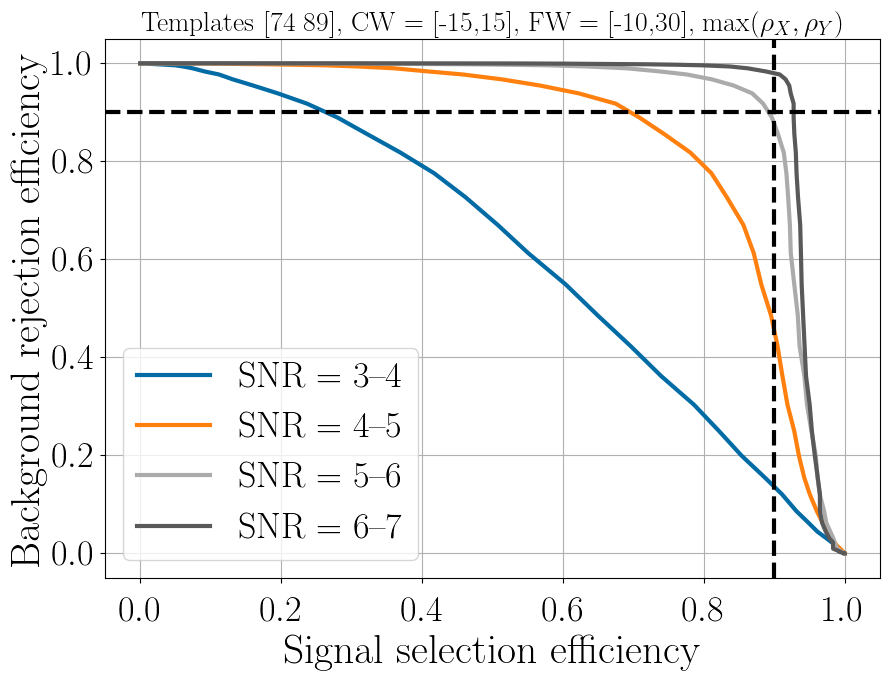

In [25]:
corr_thresh = np.arange(0,1,.01)

bkg_sel_eff = get_selection_efficiency(bkg_results['corr_max'],corr_thresh)
bkg_rej_eff = 1 - bkg_sel_eff

# bkg_sel_eff_1khz = get_selection_efficiency(bkg_ts_1khz,ts_thresh)
# bkg_rej_eff_1khz = 1 - bkg_sel_eff_1khz

for snr_bin, snr_mask in zip( snr_masks.keys(), snr_masks.values() ):
    sig_sel_eff = get_selection_efficiency(sig_results['corr_max'][snr_mask],corr_thresh)
    plt.plot(sig_sel_eff,bkg_rej_eff,label=f'SNR = {snr_bin}--{snr_bin+snr_bin_width}')

plt.axhline(0.9,color='k',linestyle='--')
plt.axvline(0.9,color='k',linestyle='--')

plt.xlabel('Signal selection efficiency')
plt.ylabel('Background rejection efficiency')
plt.title(title_str+r', $\max(\rho_X,\rho_Y)$',fontsize=20)

plt.legend(frameon=True,framealpha=.8)

if savefig:
    plot_name = 'sig_sel_vs_bkg_rej_efficiency_TF' # + param_str
    
    plt.savefig( os.path.join(plot_dir,plot_name+'.png') )
    plt.savefig( os.path.join(plot_dir,plot_name+'.pdf') )

plt.show()

## Look at all possible combinations of best doublet + random singlet

In [31]:
n_random           = 3
trials             = np.arange(96)
corr_window        = [-15,15]
fit_window         = [-10,30]
corr_thresh        = np.arange(0,1,.01)
pol                = 'XY'
n_pol              = len(pol)
sig_sel_eff_thresh = 0.9

sig_test_file = '/sps/grand/pcorrea/nutrig/database/sig/sig_dataset_nutrig_gp13_train_seed_300.npz'

with np.load(sig_test_file) as f:
    sig_traces = f['traces']
    sig_snr    = f['snr']
    sig_flags  = f['pretrig_flags']
    sig_snr    = tools.get_snr(sig_traces,f['inj_pulse_times'])
    sig_snr    = np.max(sig_snr[:,:2],axis=1)

snr_bin_width = 1
snr_bin_edges = np.arange(3,7.1,snr_bin_width)

snr_masks = {snr_bin : None for snr_bin in snr_bin_edges[:-1]}

for snr_bin in snr_masks.keys():
    snr_masks[snr_bin] = np.where( np.logical_and( sig_snr>=snr_bin, sig_snr<snr_bin+snr_bin_width ), True, False )

In [34]:
bkg_rej_eff_vals   = np.zeros((len(trials),len(snr_bin_edges)-1))

for k, trial in enumerate(trials):
    print(k) 
    param_str = f'templates_random_{k}_{n_random}_cw_{corr_window[0]}_{corr_window[1]}_fw_{fit_window[0]}_{fit_window[1]}'

    bkg_train_res_file = f'/sps/grand/pcorrea/nutrig/template/results_random/results_template_FLT_{pol}_bkg_dataset_nutrig_gp13_train_seed_300_{param_str}.npz'
    with np.load(bkg_train_res_file) as f:
        bkg_corr_best_all     = f['corr_best']
        bkg_idx_template_best = f['idx_template_best']

    sig_train_res_file = f'/sps/grand/pcorrea/nutrig/template/results_random/results_template_FLT_{pol}_sig_dataset_nutrig_gp13_train_seed_300_{param_str}.npz'
    with np.load(sig_train_res_file) as f:
        sig_corr_best_all     = f['corr_best']
        sig_idx_template_best = f['idx_template_best']


    bkg_corr_max  = np.zeros(bkg_corr_best_all.shape[0])
    sig_corr_max  = np.zeros(sig_corr_best_all.shape[0])

    for i in range(n_pol):
        bkg_corr_best_pol = np.abs( np.take_along_axis(bkg_corr_best_all[:,i],bkg_idx_template_best[:,i,None],axis=1)[:,0] )      
        bkg_corr_max      = np.where(bkg_corr_best_pol>bkg_corr_max,bkg_corr_best_pol,bkg_corr_max)

        sig_corr_best_pol = np.abs( np.take_along_axis(sig_corr_best_all[:,i],sig_idx_template_best[:,i,None],axis=1)[:,0] )
        sig_corr_max      = np.where(sig_corr_best_pol>sig_corr_max,sig_corr_best_pol,sig_corr_max)
    
    bkg_sel_eff = get_selection_efficiency(bkg_corr_max,corr_thresh)

    for j, snr_mask in enumerate( snr_masks.values() ):
        sig_sel_eff = get_selection_efficiency(sig_corr_max[snr_mask],corr_thresh)
        idx         = np.where(sig_sel_eff>=sig_sel_eff_thresh)[0][-1]
        bkg_rej_eff_vals[k,j] = 1 - bkg_sel_eff[idx]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95


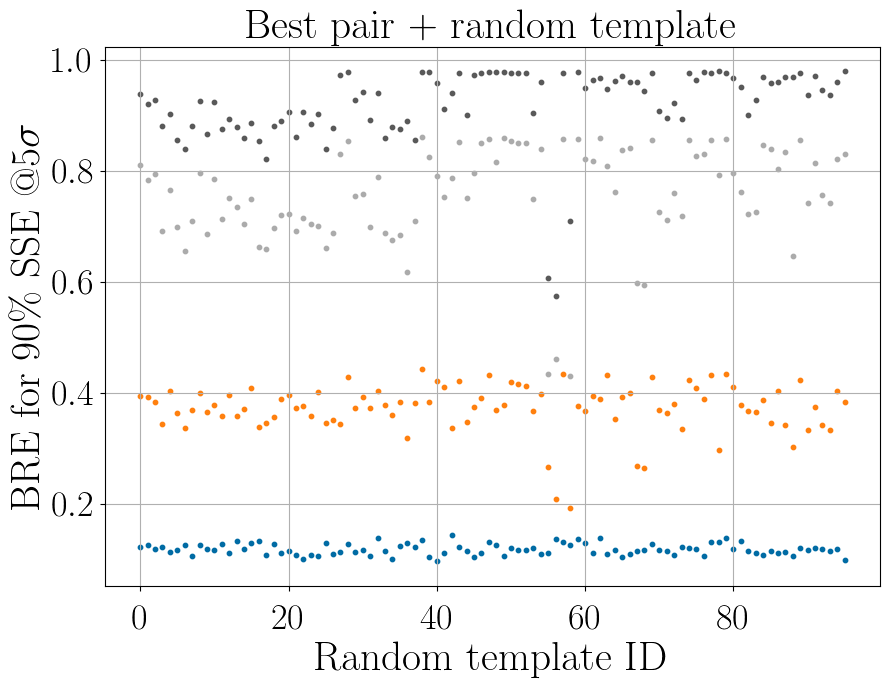

In [35]:
for i in range(bkg_rej_eff_vals.shape[1]):
    plt.scatter(trials,bkg_rej_eff_vals[:,i],label=f'SNR = {snr_bin_edges[i]}--{snr_bin_edges[i]+snr_bin_width}',marker='o',s=10)

plt.xlabel('Random template ID')
plt.ylabel('BRE for 90\% SSE @$5\sigma$')

plt.title('Best pair + random template')

# array([0.1437, 0.4406, 0.8553, 0.9772])

plt.show()

In [36]:
best_idx     = np.argmax(bkg_rej_eff_vals[:,2]) # for SNR = 5
best_triplet = np.sort( np.append( best_pair, [best_idx] ) )

In [39]:
n_templates   = 3
corr_window   = [-15,15]
fit_window    = [-10,30]
pol           = 'XY'
n_pol         = len(pol)
dataset       = 'train' # or 'test' for final checks
snr_bin_width = 1

param_str = f'templates_random_{best_idx}_{n_random}_cw_{corr_window[0]}_{corr_window[1]}_fw_{fit_window[0]}_{fit_window[1]}'
title_str = f'Templates {best_triplet}, CW = [{corr_window[0]},{corr_window[1]}], FW = [{fit_window[0]},{fit_window[1]}]'

plot_dir = '/pbs/home/p/pcorrea/grand/nutrig/flt/plots'
savefig  = False

bkg_res_file     = f'/sps/grand/pcorrea/nutrig/template/results_random/results_template_FLT_{pol}_bkg_dataset_nutrig_gp13_{dataset}_seed_300_{param_str}.npz'
sig_res_file     = f'/sps/grand/pcorrea/nutrig/template/results_random/results_template_FLT_{pol}_sig_dataset_nutrig_gp13_{dataset}_seed_300_{param_str}.npz'
sig_dataset_file = f'/sps/grand/pcorrea/nutrig/database/sig/sig_dataset_nutrig_gp13_{dataset}_seed_300.npz'

bkg_results = load_results(bkg_res_file,n_pol)
sig_results = load_results(sig_res_file,n_pol)
snr_masks   = get_snr_masks(sig_dataset_file,snr_bin_width=snr_bin_width)

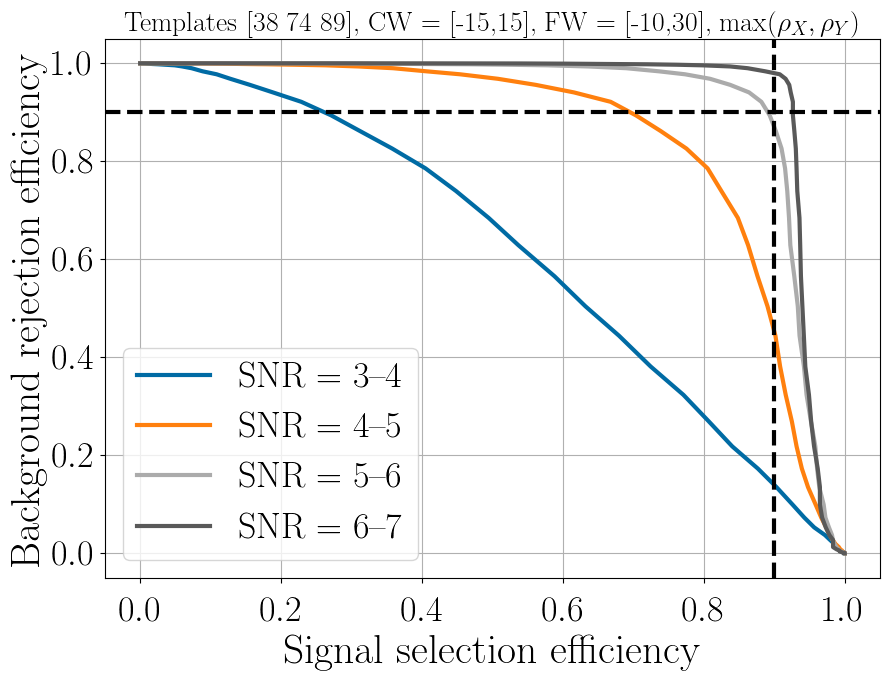

In [40]:
corr_thresh = np.arange(0,1,.01)

bkg_sel_eff = get_selection_efficiency(bkg_results['corr_max'],corr_thresh)
bkg_rej_eff = 1 - bkg_sel_eff

# bkg_sel_eff_1khz = get_selection_efficiency(bkg_ts_1khz,ts_thresh)
# bkg_rej_eff_1khz = 1 - bkg_sel_eff_1khz

for snr_bin, snr_mask in zip( snr_masks.keys(), snr_masks.values() ):
    sig_sel_eff = get_selection_efficiency(sig_results['corr_max'][snr_mask],corr_thresh)
    plt.plot(sig_sel_eff,bkg_rej_eff,label=f'SNR = {snr_bin}--{snr_bin+snr_bin_width}')

plt.axhline(0.9,color='k',linestyle='--')
plt.axvline(0.9,color='k',linestyle='--')

plt.xlabel('Signal selection efficiency')
plt.ylabel('Background rejection efficiency')
plt.title(title_str+r', $\max(\rho_X,\rho_Y)$',fontsize=20)

plt.legend(frameon=True,framealpha=.8)

if savefig:
    plot_name = 'sig_sel_vs_bkg_rej_efficiency_TF' # + param_str
    
    plt.savefig( os.path.join(plot_dir,plot_name+'.png') )
    plt.savefig( os.path.join(plot_dir,plot_name+'.pdf') )

plt.show()

## Look at best singlet

In [48]:
n_random           = 1
trials             = np.arange(96)
corr_window        = [-15,15]
fit_window         = [-10,30]
corr_thresh        = np.arange(0,1,.01)
pol                = 'XY'
n_pol              = len(pol)
sig_sel_eff_thresh = 0.9

sig_test_file = '/sps/grand/pcorrea/nutrig/database/sig/sig_dataset_nutrig_gp13_train_seed_300.npz'

with np.load(sig_test_file) as f:
    sig_traces = f['traces']
    sig_snr    = f['snr']
    sig_flags  = f['pretrig_flags']
    sig_snr    = tools.get_snr(sig_traces,f['inj_pulse_times'])
    sig_snr    = np.max(sig_snr[:,:2],axis=1)

snr_bin_width = 1
snr_bin_edges = np.arange(3,7.1,snr_bin_width)

snr_masks = {snr_bin : None for snr_bin in snr_bin_edges[:-1]}

for snr_bin in snr_masks.keys():
    snr_masks[snr_bin] = np.where( np.logical_and( sig_snr>=snr_bin, sig_snr<snr_bin+snr_bin_width ), True, False )

In [49]:
bkg_rej_eff_vals   = np.zeros((len(trials),len(snr_bin_edges)-1))

for k, trial in enumerate(trials): 
    param_str = f'templates_random_{k}_{n_random}_cw_{corr_window[0]}_{corr_window[1]}_fw_{fit_window[0]}_{fit_window[1]}'

    bkg_train_res_file = f'/sps/grand/pcorrea/nutrig/template/results_random/results_template_FLT_{pol}_bkg_dataset_nutrig_gp13_train_seed_300_{param_str}.npz'
    with np.load(bkg_train_res_file) as f:
        bkg_corr_best_all     = f['corr_best']
        bkg_idx_template_best = f['idx_template_best']

    sig_train_res_file = f'/sps/grand/pcorrea/nutrig/template/results_random/results_template_FLT_{pol}_sig_dataset_nutrig_gp13_train_seed_300_{param_str}.npz'
    with np.load(sig_train_res_file) as f:
        sig_corr_best_all     = f['corr_best']
        sig_idx_template_best = f['idx_template_best']


    bkg_corr_max  = np.zeros(bkg_corr_best_all.shape[0])
    sig_corr_max  = np.zeros(sig_corr_best_all.shape[0])

    for i in range(n_pol):
        bkg_corr_best_pol = np.abs( np.take_along_axis(bkg_corr_best_all[:,i],bkg_idx_template_best[:,i,None],axis=1)[:,0] )      
        bkg_corr_max      = np.where(bkg_corr_best_pol>bkg_corr_max,bkg_corr_best_pol,bkg_corr_max)

        sig_corr_best_pol = np.abs( np.take_along_axis(sig_corr_best_all[:,i],sig_idx_template_best[:,i,None],axis=1)[:,0] )
        sig_corr_max      = np.where(sig_corr_best_pol>sig_corr_max,sig_corr_best_pol,sig_corr_max)
    
    bkg_sel_eff = get_selection_efficiency(bkg_corr_max,corr_thresh)

    for j, snr_mask in enumerate( snr_masks.values() ):
        sig_sel_eff = get_selection_efficiency(sig_corr_max[snr_mask],corr_thresh)
        idx         = np.where(sig_sel_eff>=sig_sel_eff_thresh)[0][-1]
        bkg_rej_eff_vals[k,j] = 1 - bkg_sel_eff[idx]

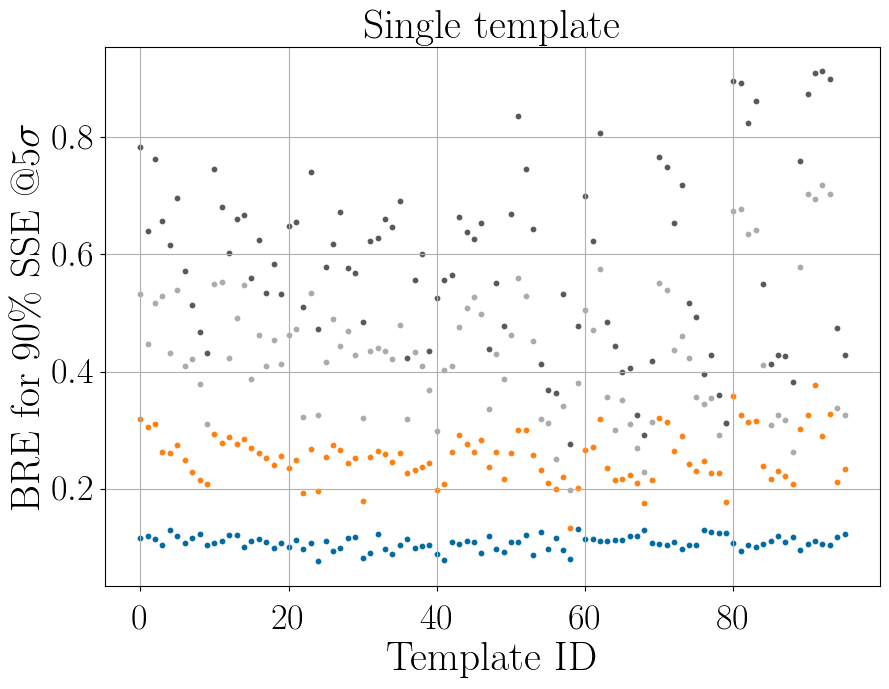

In [50]:
for i in range(bkg_rej_eff_vals.shape[1]):
    plt.scatter(trials,bkg_rej_eff_vals[:,i],label=f'SNR = {snr_bin_edges[i]}--{snr_bin_edges[i]+snr_bin_width}',marker='o',s=10)

plt.xlabel('Template ID')
plt.ylabel('BRE for 90\% SSE @$5\sigma$')

plt.title('Single template')

# array([0.1437, 0.4406, 0.8553, 0.9772])

plt.show()

In [53]:
best_singlet = np.argmax(bkg_rej_eff_vals[:,2]) # for SNR = 5

92

In [54]:
n_templates   = 1
corr_window   = [-15,15]
fit_window    = [-10,30]
pol           = 'XY'
n_pol         = len(pol)
dataset       = 'train' # or 'test' for final checks
snr_bin_width = 1

param_str = f'templates_random_{best_singlet}_{n_random}_cw_{corr_window[0]}_{corr_window[1]}_fw_{fit_window[0]}_{fit_window[1]}'
title_str = f'Template {best_singlet}, CW = [{corr_window[0]},{corr_window[1]}], FW = [{fit_window[0]},{fit_window[1]}]'

plot_dir = '/pbs/home/p/pcorrea/grand/nutrig/flt/plots'
savefig  = False

bkg_res_file     = f'/sps/grand/pcorrea/nutrig/template/results_random/results_template_FLT_{pol}_bkg_dataset_nutrig_gp13_{dataset}_seed_300_{param_str}.npz'
sig_res_file     = f'/sps/grand/pcorrea/nutrig/template/results_random/results_template_FLT_{pol}_sig_dataset_nutrig_gp13_{dataset}_seed_300_{param_str}.npz'
sig_dataset_file = f'/sps/grand/pcorrea/nutrig/database/sig/sig_dataset_nutrig_gp13_{dataset}_seed_300.npz'

bkg_results = load_results(bkg_res_file,n_pol)
sig_results = load_results(sig_res_file,n_pol)
snr_masks   = get_snr_masks(sig_dataset_file,snr_bin_width=snr_bin_width)

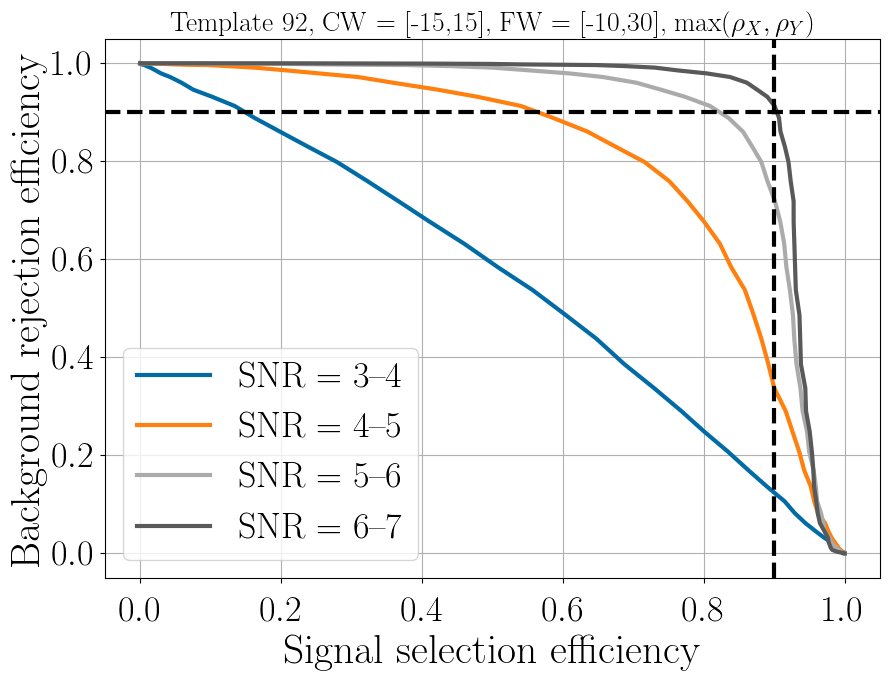

In [55]:
corr_thresh = np.arange(0,1,.01)

bkg_sel_eff = get_selection_efficiency(bkg_results['corr_max'],corr_thresh)
bkg_rej_eff = 1 - bkg_sel_eff

# bkg_sel_eff_1khz = get_selection_efficiency(bkg_ts_1khz,ts_thresh)
# bkg_rej_eff_1khz = 1 - bkg_sel_eff_1khz

for snr_bin, snr_mask in zip( snr_masks.keys(), snr_masks.values() ):
    sig_sel_eff = get_selection_efficiency(sig_results['corr_max'][snr_mask],corr_thresh)
    plt.plot(sig_sel_eff,bkg_rej_eff,label=f'SNR = {snr_bin}--{snr_bin+snr_bin_width}')

plt.axhline(0.9,color='k',linestyle='--')
plt.axvline(0.9,color='k',linestyle='--')

plt.xlabel('Signal selection efficiency')
plt.ylabel('Background rejection efficiency')
plt.title(title_str+r', $\max(\rho_X,\rho_Y)$',fontsize=20)

plt.legend(frameon=True,framealpha=.8)

if savefig:
    plot_name = 'sig_sel_vs_bkg_rej_efficiency_TF' # + param_str
    
    plt.savefig( os.path.join(plot_dir,plot_name+'.png') )
    plt.savefig( os.path.join(plot_dir,plot_name+'.pdf') )

plt.show()

## Plot some templates of choice

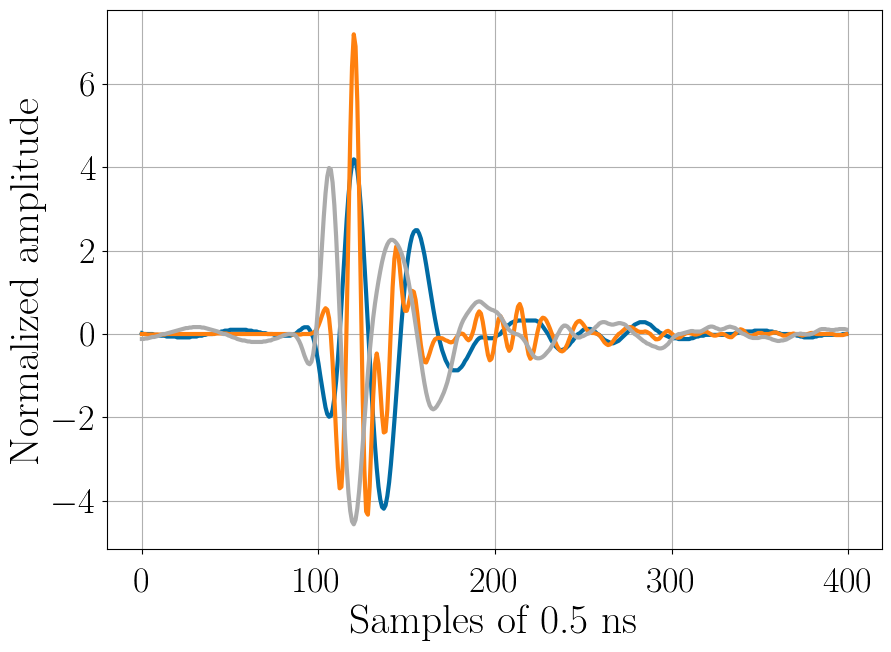

In [17]:
pol = 'XY'
rf_chain = 'rfv2'
n_templates = 96
savefig = False

lib_path  = '/sps/grand/pcorrea/nutrig/template/lib/'
lib_name  = 'templates_{}_{}_{}.npz'.format(n_templates,pol,rf_chain)
meta_name = 'metadata_{}_{}_{}.npz'.format(n_templates,pol,rf_chain)

f = np.load(lib_path+lib_name)
templates = f['templates'][[74,89,38],:]
#templates = f['templates'][[92],:]

fig, ax = plt.subplots()

ax.plot(templates.T)

ax.set_xlabel('Samples of 0.5 ns')
ax.set_ylabel('Normalized amplitude')

if savefig:
    plot_name = 'templates_XY'
    
    plt.savefig( os.path.join(plot_dir,plot_name+'.png') )
    plt.savefig( os.path.join(plot_dir,plot_name+'.pdf') )

plt.show()

In [19]:
1.648e-6*360*24*90

1.2814848